# Import all packages

In [1]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# Efficient Looping
import itertools

# Traceback for diagnosis
import traceback

# Data Visualization
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Fine-tuning 
import optuna

# Randomizer
import random


# OS
import os

# Image package
from PIL import Image

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

# Importing Keras 
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer 
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                         # Layer for activation functions
from keras.layers import Concatenate, Input, GlobalAveragePooling2D # To concatenate two models together
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models
# Preprocessing layers
from keras.layers import Rescaling                           # This layer rescales pixel values
from keras.applications import ResNet50V2                   # Use for ResnetV2
# Importing TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Model
import shap
import os
from PIL import Image
import tensorflow as tf  # Assuming `model` is a TensorFlow/Keras model
from sklearn.metrics import classification_report
from collections import Counter

c:\Users\Jon\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



# Gather Data 

In [2]:
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'

In [3]:
# Making sure all images are the same pixel dimensions
def image_resizer(paths):
    """
    This function resizes the input images
    """
    with ThreadPoolExecutor() as executor:
        resized_images = list(executor.map(lambda x: Image.open(x).resize((350,250)), paths))
    return resized_images

# Used in source examples but I never implemented them here
def plot_images_list(images, title, subtitle):
    '''
    This functions helps to plot a matrix of images in a list
    '''
    fig = sp.make_subplots(rows=3, cols=3)
    images = image_resizer(images)
    
    traces = []
    for i in range(min(9, len(images))):
        img = go.Image(z=images[i])
        traces.append((img, i//3+1, i%3+1))
        
    fig.add_traces([trace[0] for trace in traces],
                  rows = [trace[1] for trace in traces],
                  cols = [trace[2] for trace in traces])

    fig.update_layout(
        title={'text': f'<b>{title}<br>  <i><sub>{subtitle}</sub></i></b>',
               'font': dict(size = 22)},
        height=800,
        width=800,
        margin=dict(t=110, l=80),
        plot_bgcolor=bg_color,paper_bgcolor=paper_color
        #template=template
    )
    fig.show()

### Locate where the data is

In [3]:
import os

##### I switched back and forth between my laptop and desktop so I saved the file path to both
# begin_path = 'C:/Users/jonpg/OneDrive/Documents/School/CS 770/covid_data/'
begin_path = 'C:/Users/Jon/Documents/School/CS 770/covid_data/'

train_dir = begin_path + 'train'
validation_dir = begin_path + 'validation'
test_dir = begin_path + 'test'
# Giving names to each directory
directories = {
    'train_dir': train_dir,
    'validation_dir': validation_dir,
    'test_dir': test_dir
    }

# Naming subfolders, this is where I should have switched the labels, so that covid was a positive outcome
subfolders = ['covid', 'normal']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for name, dir  in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)


* * * * * Number of files in each folder * * * * *


train_dir/covid: 8280

train_dir/normal: 7220

  Total: 15500
--------------------------------------------------------------------------------

validation_dir/covid: 330

validation_dir/normal: 978

  Total: 1308
--------------------------------------------------------------------------------

test_dir/covid: 526

test_dir/normal: 1994

  Total: 2520
--------------------------------------------------------------------------------


### Doing some semi EDA 

In [ ]:
unique_dimensions = set()

for name, dir in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)
        
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                unique_dimensions.add(img.size)
                
if len(unique_dimensions) == 1:
    print(f"\nAll images have the same dimensions: {unique_dimensions.pop()}")
else:
    print(f"\nFound {len(unique_dimensions)} unique image dimensions: {unique_dimensions}")


All images have the same dimensions: (299, 299)


In [ ]:
# Checking if all the images in the dataset have the same dimensions
dims_counts = defaultdict(int)

for name,dir in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)
        
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                dims_counts[img.size] += 1
                
for dimension, count in dims_counts.items():
    print(f"\nDimension {dimension}: {count} images")


Dimension (299, 299): 16568 images


In [ ]:
# Checking images dtype
all_uint8 = True
all_in_range = True

for name, dir in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)
        
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                img_array = np.array(img)
                
            if img_array.dtype == 'uint8':
                all_uint8 = False
            
            if img_array.min() < 0 or img_array.max() > 255:
                all_in_range = False
                
if all_uint8:
    print(" - All images are of data type uint8\n")
else:
    print(" - Not all images are of data type uint8\n")
    
if all_in_range:
    print(" - All images have pixel values ranging from 0 to 255")
else:
    print(" - Not all images have the same pixel values from 0 to 255")

 - Not all images are of data type uint8

 - All images have pixel values ranging from 0 to 255


In [ ]:
############# I do not remember why I had this#################### (but lets not delete it lol)

# # Loading the directory for each class in the training dataset
# train_list =[]
# for sub in subfolders:
#     train_list.append(train_dir+'/'+sub)

# files_dict = {}
# # Selecting 9 random pictures from each directory
# for path in train_list:
#     files_dict[path] = random.sample(os.listdir(path), 9)

### Grab all three datasets

In [8]:
seed = 42
# Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = subfolders,
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (256, 256), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 15500 files belonging to 2 classes.


In [9]:
# Creating a dataset for the Test data
validation = tf.keras.utils.image_dataset_from_directory(
    validation_dir,  
    labels = 'inferred', 
    label_mode = 'categorical',
    class_names = subfolders,
    batch_size = 16,    
    image_size = (256, 256), 
    shuffle = True,  
    seed = seed,  
    validation_split = 0, 
    crop_to_aspect_ratio = True 
)

Found 1308 files belonging to 2 classes.


In [10]:
# Creating a dataset for the Test data
test = tf.keras.utils.image_dataset_from_directory(
    test_dir,  
    labels = 'inferred', 
    label_mode = 'categorical',
    class_names = subfolders,
    batch_size = 16,    
    image_size = (256, 256), 
    shuffle = True,  
    seed = seed,  
    validation_split = 0, 
    crop_to_aspect_ratio = True 
)

Found 2520 files belonging to 2 classes.


In [11]:
print('\nTraining Dataset:', train)
print('\nTraining Dataset:', validation)
print('\nTesting Dataset:', test)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [12]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)
    
    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())
    
print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 255.0


### Standardize images

In [13]:
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1

In [14]:
# Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y)) 
validation = validation.map(lambda x, y: (scaler(x), y))

test = test.map(lambda x, y: (scaler(x), y))

In [15]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)
    
    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())
    
print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


# CNN 

## Creating the model

In [ ]:
# Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = seed),
        
        
        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = seed),
        
        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = seed)
    ]
)

In [ ]:
augmentation.build((None, 256, 256, 3)) # Building model
# Plotting model
augmentation.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 random_brightness (RandomB  (None, 256, 256, 3)       0         
 rightness)                                                      
                                                                 
 random_contrast (RandomCon  (None, 256, 256, 3)       0         
 trast)                                                          
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Initiating model on GPU
# with strategy.scope():
model = Sequential()

model.add(augmentation) # Adding data augmentation pipeline to the model

# Feature Learning Layers
model.add(Conv2D(32,                  # Number of filters/Kernels
                    (3,3),               # Size of kernels (3x3 matrix)
                    strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                    padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input. 
                input_shape = (256,256,3) # Input image shape
                ))
model.add(Activation('relu'))# Activation function
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(256, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

# Flattening tensors
model.add(Flatten())

# Fully-Connected Layers
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(len(subfolders), activation = 'softmax')) # Classification layer

## Define training parameters

In [ ]:
# Compiling model
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'categorical_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric

In [ ]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint(begin_path + 'best_model_v2.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [ ]:
# Training and Testing Model
try:
    history = model.fit(
        train, epochs = 50,
        validation_data = validation,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

Epoch 1/50
969/969 [==============================] - 838s 863ms/step - loss: 1.4185 - accuracy: 0.6101 - val_loss: 9.1899 - val_accuracy: 0.2523
Epoch 2/50
969/969 [==============================] - 808s 833ms/step - loss: 0.6497 - accuracy: 0.6737 - val_loss: 2.4319 - val_accuracy: 0.2745
Epoch 3/50
969/969 [==============================] - 826s 852ms/step - loss: 0.5927 - accuracy: 0.7214 - val_loss: 0.5674 - val_accuracy: 0.7622
Epoch 4/50
969/969 [==============================] - 809s 835ms/step - loss: 0.5456 - accuracy: 0.7517 - val_loss: 10.3487 - val_accuracy: 0.2546
Epoch 5/50
969/969 [==============================] - 828s 854ms/step - loss: 0.4897 - accuracy: 0.7835 - val_loss: 7.7295 - val_accuracy: 0.3739
Epoch 6/50
969/969 [==============================] - 815s 841ms/step - loss: 0.4511 - accuracy: 0.8087 - val_loss: 0.2381 - val_accuracy: 0.9220
Epoch 7/50
969/969 [==============================] - 814s 840ms/step - loss: 0.4198 - accuracy: 0.8314 - val_loss: 6.5615 

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_5 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128, 128, 32)     

## Post Analysis

In [ ]:
# Creating subplot
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Test',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
fig.show()

In [ ]:
# Loading best weights
model.load_weights(begin_path + 'best_model_v2.h5')

In [ ]:
# preds = model.predict(validation)  # Running model on the test dataset
val_loss, val_acc = model.evaluate(test) # Obtaining Loss and Accuracy on the test dataset

print('\nTest Loss: ', val_loss)
print('\nTest Accuracy: ', np.round(val_acc * 100), '%')

158/158 [==============================] - 23s 146ms/step - loss: 0.2877 - accuracy: 0.9270

Test Loss:  0.28766706585884094

Test Accuracy:  93.0 %


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf  # Assuming `model` is a TensorFlow/Keras model
from sklearn.metrics import classification_report
from collections import Counter

# Load your model (ensure you have it defined or loaded elsewhere)
model = tf.keras.models.load_model(begin_path + 'covid_classifier_v2 - best.h5')  # Update with actual model path

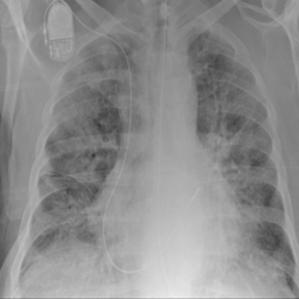

In [ ]:
image_path = begin_path + 'test/covid/COVID-579.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size
original_image

# Resizing image for optimal performance
# new_width = int(og_width * .20) # 20% of the original size
# new_height = int(og_height * .20) # 20% of the original size

# resized_img = original_image.resize((new_width, new_height))
# print('Picture of normal: \n')
# resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = subfolders

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 0s 329ms/step

Predicted Class: covid

Confidence Score: 0.999902606010437


In [ ]:
model.save(begin_path + 'covid_classifier_v2.h5')

### Manual inference to get classification report
This was to give the highest confidence in the models performance

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf  # Assuming `model` is a TensorFlow/Keras model
from sklearn.metrics import classification_report
from collections import Counter

# Load your model (ensure you have it defined or loaded elsewhere)
model = tf.keras.models.load_model(begin_path + 'covid_classifier_v2 - best.h5')  # Update with actual model path

# Define the folder containing images
folder_path = begin_path + 'test/normal'  # Update with your folder path
labels = subfolders  # Assuming labels are subfolder names


output = []
# Iterate through all image files in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
        image_path = os.path.join(folder_path, filename)

        # Open and preprocess the image
        original_image = Image.open(image_path)
        preprocessed_image = original_image.resize((256, 256))
        preprocessed_image = np.array(preprocessed_image) / 255.0

        # Make prediction
        preds = model.predict(np.expand_dims(preprocessed_image, axis=0))
        
        preds_class = np.argmax(preds)
        preds_label = labels[preds_class]
        output.append(preds_label)
        # # Print results
        # print(f'\nImage: {filename}')
        # print(f'Predicted Class: {preds_label}')
        # print(f'Confidence Score: {preds[0][preds_class]}')
counts = Counter(output)
TP = counts['normal']
FN = counts['covid']

folder_path = begin_path + 'test/covid'  # Update with your folder path
labels = subfolders  # Assuming labels are subfolder names


output = []
# Iterate through all image files in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
        image_path = os.path.join(folder_path, filename)

        # Open and preprocess the image
        original_image = Image.open(image_path)
        preprocessed_image = original_image.resize((256, 256))
        preprocessed_image = np.array(preprocessed_image) / 255.0

        # Make prediction
        preds = model.predict(np.expand_dims(preprocessed_image, axis=0))
        
        preds_class = np.argmax(preds)
        preds_label = labels[preds_class]
        output.append(preds_label)
        # # Print results
        # print(f'\nImage: {filename}')
        # print(f'Predicted Class: {preds_label}')
        # print(f'Confidence Score: {preds[0][preds_class]}')
counts = Counter(output)
TN = counts['covid']
FP = counts['normal']

# Reconstruct y_true and y_pred
y_true = np.array([0] * (TN + FP) + [1] * (TP + FN))  # First class 0, then class 1
y_pred = np.array([0] * TN + [1] * FP + [0] * FN + [1] * TP)  # Predictions based on confusion matrix

# Generate classification report
print(classification_report(y_true, y_pred))

1/1 [==============================] - 0s 37ms/step
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       526
           1       0.98      0.93      0.96      1994

    accuracy                           0.94      2520
   macro avg       0.89      0.94      0.91      2520
weighted avg       0.94      0.94      0.94      2520



# RESNET50V2

## Creating Model

In [ ]:
pre_resnet_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=2,
    classifier_activation="softmax"
)

resnet_model = Sequential()
resnet_model.add(pre_resnet_model)
# Flattening tensors
resnet_model.add(Flatten())

# Fully-Connected Layers
resnet_model.add(Dense(2048))
resnet_model.add(Activation('relu'))
resnet_model.add(Dropout(0.5))

# Output Layer
resnet_model.add(Dense(len(subfolders), activation = 'softmax')) # Classification layer


In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_1 (Dense)             (None, 2048)              268437504 
                                                                 
 activation_5 (Activation)   (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 292006402 (1.09 GB)
Trainable params: 29

In [ ]:
# Compiling model
resnet_model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'categorical_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric

In [ ]:
# Training and Testing Model
try:
    history = resnet_model.fit(
        train, epochs = 50,
        validation_data = validation,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

Epoch 1/50
969/969 [==============================] - 2142s 2s/step - loss: 0.2346 - accuracy: 0.9599 - val_loss: 0.1622 - val_accuracy: 0.9847
Epoch 2/50
969/969 [==============================] - 2074s 2s/step - loss: 0.0583 - accuracy: 0.9861 - val_loss: 0.2196 - val_accuracy: 0.9572
Epoch 3/50
969/969 [==============================] - 2054s 2s/step - loss: 0.0365 - accuracy: 0.9926 - val_loss: 0.1485 - val_accuracy: 0.9664
Epoch 4/50
969/969 [==============================] - 2041s 2s/step - loss: 0.0218 - accuracy: 0.9954 - val_loss: 0.1488 - val_accuracy: 0.9817
Epoch 5/50
969/969 [==============================] - 2028s 2s/step - loss: 0.0276 - accuracy: 0.9953 - val_loss: 1.4852 - val_accuracy: 0.9243
Epoch 6/50
969/969 [==============================] - 2044s 2s/step - loss: 0.0122 - accuracy: 0.9974 - val_loss: 0.2106 - val_accuracy: 0.9862
Epoch 7/50
969/969 [==============================] - 2055s 2s/step - loss: 0.0113 - accuracy: 0.9978 - val_loss: 0.1608 - val_accuracy:

## Post Analysis

In [ ]:
# Creating subplot
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Test',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
fig.show()

In [ ]:
# Loading best weights
resnet_model.load_weights(begin_path + 'best_resnet_v2.h5')

In [ ]:
# preds = model.predict(validation)  # Running model on the test dataset
val_loss, val_acc = resnet_model.evaluate(validation) # Obtaining Loss and Accuracy on the test dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

82/82 [==============================] - 30s 366ms/step - loss: 0.0869 - accuracy: 0.9878

Validation Loss:  0.08686680346727371

Validation Accuracy:  99.0 %


In [ ]:
# preds = model.predict(validation)  # Running model on the test dataset
val_loss, val_acc = resnet_model.evaluate(test) # Obtaining Loss and Accuracy on the test dataset

print('\nTest Loss: ', val_loss)
print('\nTest Accuracy: ', np.round(val_acc * 100), '%')

158/158 [==============================] - 59s 365ms/step - loss: 0.0552 - accuracy: 0.9925

Test Loss:  0.05516219884157181

Test Accuracy:  99.0 %


In [ ]:
resnet_model.save(begin_path + 'covid_resnet_classifier_v2.h5')

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf  # Assuming `model` is a TensorFlow/Keras model
from sklearn.metrics import classification_report
from collections import Counter

# Load your model (ensure you have it defined or loaded elsewhere)
model = tf.keras.models.load_model(begin_path + 'covid_resnet_classifier_v2.h5')  # Update with actual model path

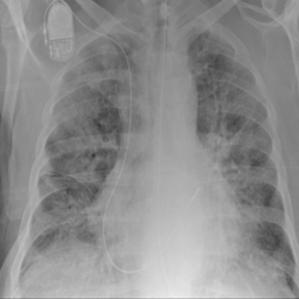

In [ ]:
image_path = begin_path + 'test/covid/COVID-579.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size
original_image

# Resizing image for optimal performance
# new_width = int(og_width * .20) # 20% of the original size
# new_height = int(og_height * .20) # 20% of the original size

# resized_img = original_image.resize((new_width, new_height))
# print('Picture of normal: \n')
# resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = subfolders

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 1s 514ms/step

Predicted Class: covid

Confidence Score: 1.0


## Again manual inference
This was definitely important here, seeing how high the accuracy was I had doubts

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf  # Assuming `model` is a TensorFlow/Keras model
from sklearn.metrics import classification_report
from collections import Counter

# Load your model (ensure you have it defined or loaded elsewhere)
model = tf.keras.models.load_model(begin_path + 'covid_resnet_classifier_v2.h5')  # Update with actual model path

# Define the folder containing images
folder_path = begin_path + 'test/normal'  # Update with your folder path
labels = subfolders  # Assuming labels are subfolder names


output = []
# Iterate through all image files in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
        image_path = os.path.join(folder_path, filename)

        # Open and preprocess the image
        original_image = Image.open(image_path)
        preprocessed_image = original_image.resize((256, 256))
        preprocessed_image = np.array(preprocessed_image) / 255.0

        # Make prediction
        preds = model.predict(np.expand_dims(preprocessed_image, axis=0))
        
        preds_class = np.argmax(preds)
        preds_label = labels[preds_class]
        output.append(preds_label)
        # # Print results
        # print(f'\nImage: {filename}')
        # print(f'Predicted Class: {preds_label}')
        # print(f'Confidence Score: {preds[0][preds_class]}')
counts = Counter(output)
TP = counts['normal']
FN = counts['covid']

folder_path = begin_path + 'test/covid'  # Update with your folder path
labels = subfolders  # Assuming labels are subfolder names


output = []
# Iterate through all image files in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
        image_path = os.path.join(folder_path, filename)

        # Open and preprocess the image
        original_image = Image.open(image_path)
        preprocessed_image = original_image.resize((256, 256))
        preprocessed_image = np.array(preprocessed_image) / 255.0

        # Make prediction
        preds = model.predict(np.expand_dims(preprocessed_image, axis=0))
        
        preds_class = np.argmax(preds)
        preds_label = labels[preds_class]
        output.append(preds_label)
        # # Print results
        # print(f'\nImage: {filename}')
        # print(f'Predicted Class: {preds_label}')
        # print(f'Confidence Score: {preds[0][preds_class]}')
counts = Counter(output)
TN = counts['covid']
FP = counts['normal']

# Reconstruct y_true and y_pred
y_true = np.array([0] * (TN + FP) + [1] * (TP + FN))  # First class 0, then class 1
y_pred = np.array([0] * TN + [1] * FP + [0] * FN + [1] * TP)  # Predictions based on confusion matrix

# Generate classification report
print(classification_report(y_true, y_pred))

1/1 [==============================] - 0s 100ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       526
           1       0.99      1.00      1.00      1994

    accuracy                           0.99      2520
   macro avg       0.99      0.99      0.99      2520
weighted avg       0.99      0.99      0.99      2520



# ResNet50V2 and CNN Concatenation

## The CNN First

In [ ]:
seed = 42
# Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = seed),
        
        
        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = seed),
        
        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = seed)
    ]
)

In [ ]:
augmentation.build((None, 256, 256, 3)) # Building model
# Plotting model
augmentation.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 random_brightness (RandomB  (None, 256, 256, 3)       0         
 rightness)                                                      
                                                                 
 random_contrast (RandomCon  (None, 256, 256, 3)       0         
 trast)                                                          
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Below we cut the model at the conv2d_8 layer

In [ ]:
# Initiating model on GPU
# with strategy.scope():
model = Sequential()

model.add(augmentation) # Adding data augmentation pipeline to the model

# Feature Learning Layers
model.add(Conv2D(32,                  # Number of filters/Kernels
                    (3,3),               # Size of kernels (3x3 matrix)
                    strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                    padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input. 
                input_shape = (256,256,3) # Input image shape
                ))
model.add(Activation('relu'))# Activation function
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Dense(2048))


# model.add(Conv2D(256, (5,5), padding = 'same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
# model.add(Dropout(0.3))

# model.add(Conv2D(512, (3,3), padding = 'same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
# model.add(Dropout(0.3))

# # Flattening tensors
# model.add(Flatten())

# # Fully-Connected Layers
# model.add(Dense(2048))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# # Output Layer
# model.add(Dense(len(subfolders), activation = 'softmax')) # Classification layer

## Instantiate the ResNet

In [ ]:
pre_resnet_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=2,
    classifier_activation="softmax"
)

# resnet_model = Sequential()
# resnet_model.add(pre_resnet_model)
# # Flattening tensors
# resnet_model.add(Flatten())

# # Fully-Connected Layers
# resnet_model.add(Dense(2048))
# resnet_model.add(Activation('relu'))
# resnet_model.add(Dropout(0.5))

# # Output Layer
# resnet_model.add(Dense(len(subfolders), activation = 'softmax')) # Classification layer


### Cut at the conv3_block4_2_relu layer

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

# Load full model without the classification head
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Choose an intermediate layer as output — print layer names to decide
# Example: trim after 'conv3_block4_out' (or whatever layer you want)
trim_layer_name = 'conv3_block4_2_relu'
trim_output = base_model.get_layer(trim_layer_name).output

# Add your custom top
output = Dense(2048, activation='softmax')(trim_output)

# Create trimmed model
resnet_model = Model(inputs=base_model.input, outputs=output)

resnet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [ ]:
model.build((None,256,256,3))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)     

In [ ]:
pre_resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

## Combine the two
This took switching both models to the Functional API in Keras, then the process was rather simple

In [ ]:

# Get your two models (you may already have them)
model1 = model  # custom CNN
model2 = resnet_model  # ResNet50V2-based

# Define a single shared input
shared_input = Input(shape=(256, 256, 3))

# Pass the same input through both models
out1 = model1(shared_input)
out2 = model2(shared_input)


x1 = GlobalAveragePooling2D()(out1)  # shape: (None, 2048)
x2 = GlobalAveragePooling2D()(out2)  # shape: (None, 2048)

# Combine the outputs
merged = Concatenate()([x1, x2])
x = Dense(2048, activation='relu')(merged)
x = Dropout(0.5)(x)
output = Dense(len(subfolders), activation='softmax')(x)

# Final model
combined_model = Model(inputs=shared_input, outputs=output)


In [ ]:
combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 2048)         391104    ['input_3[0][0]']             
                                                                                                  
 model (Functional)          (None, 16, 16, 2048)         1651712   ['input_3[0][0]']             
                                                                                                  
 global_average_pooling2d (  (None, 2048)                 0         ['sequential_1[0][0]']        
 GlobalAveragePooling2D)                                                                    

## Compile and run

In [ ]:
# Compiling model
combined_model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'categorical_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric

In [ ]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint(begin_path + 'combined_v2.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [ ]:
# Training and Testing Model
try:
    history = combined_model.fit(
        train, epochs = 50,
        validation_data = validation,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

Epoch 1/50


969/969 [==============================] - 1254s 1s/step - loss: 0.6723 - accuracy: 0.6256 - val_loss: 0.6100 - val_accuracy: 0.6300
Epoch 2/50
969/969 [==============================] - 1256s 1s/step - loss: 0.6012 - accuracy: 0.6868 - val_loss: 0.5902 - val_accuracy: 0.6911
Epoch 3/50
969/969 [==============================] - 1266s 1s/step - loss: 0.5197 - accuracy: 0.7527 - val_loss: 0.2737 - val_accuracy: 0.8792
Epoch 4/50
969/969 [==============================] - 1266s 1s/step - loss: 0.4660 - accuracy: 0.7806 - val_loss: 0.3303 - val_accuracy: 0.8410
Epoch 5/50
969/969 [==============================] - 1272s 1s/step - loss: 0.4156 - accuracy: 0.8117 - val_loss: 1.3075 - val_accuracy: 0.5420
Epoch 6/50
969/969 [==============================] - 1289s 1s/step - loss: 0.3832 - accuracy: 0.8280 - val_loss: 1.1299 - val_accuracy: 0.5872
Epoch 7/50
969/969 [==============================] - 1275s 1s/step - loss: 0.3582 - accuracy: 0.8421 - val_loss: 0.2489 - val_accuracy: 0.9021
Epo

## Post Analysis

In [ ]:
# Creating subplot
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Test',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
fig.show()

In [ ]:
# Loading best weights
combined_model.load_weights(begin_path + 'combined_v2.h5')

In [ ]:
# preds = model.predict(validation)  # Running model on the test dataset
val_loss, val_acc = combined_model.evaluate(validation) # Obtaining Loss and Accuracy on the test dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

82/82 [==============================] - 54s 637ms/step - loss: 0.2703 - accuracy: 0.9029

Validation Loss:  0.27025270462036133

Validation Accuracy:  90.0 %


In [ ]:
# preds = model.predict(validation)  # Running model on the test dataset
val_loss, val_acc = combined_model.evaluate(test) # Obtaining Loss and Accuracy on the test dataset

print('\nTest Loss: ', val_loss)
print('\nTest Accuracy: ', np.round(val_acc * 100), '%')

158/158 [==============================] - 45s 285ms/step - loss: 0.3118 - accuracy: 0.8718

Test Loss:  0.31180045008659363

Test Accuracy:  87.0 %


In [ ]:
combined_model.save(begin_path + 'covid_combined_classifier_v2.h5')

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf  # Assuming `model` is a TensorFlow/Keras model
from sklearn.metrics import classification_report
from collections import Counter

# Load your model (ensure you have it defined or loaded elsewhere)
combined_model = tf.keras.models.load_model(begin_path + 'covid_combined_classifier_v2.h5')  # Update with actual model path

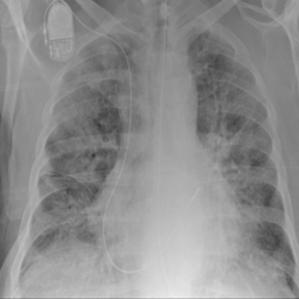

In [ ]:
image_path = begin_path + 'test/covid/COVID-579.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size
original_image

# Resizing image for optimal performance
# new_width = int(og_width * .20) # 20% of the original size
# new_height = int(og_height * .20) # 20% of the original size

# resized_img = original_image.resize((new_width, new_height))
# print('Picture of normal: \n')
# resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = combined_model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = subfolders

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 0s 288ms/step

Predicted Class: covid

Confidence Score: 0.9538732171058655


In [ ]:
preds_class

0

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf  # Assuming `model` is a TensorFlow/Keras model
from sklearn.metrics import classification_report
from collections import Counter

# Load your model (ensure you have it defined or loaded elsewhere)
model = tf.keras.models.load_model(begin_path + 'covid_combined_classifier_v2.h5')  # Update with actual model path

# Define the folder containing images
folder_path = begin_path + 'test/normal'  # Update with your folder path
labels = subfolders  # Assuming labels are subfolder names


output = []
# Iterate through all image files in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
        image_path = os.path.join(folder_path, filename)

        # Open and preprocess the image
        original_image = Image.open(image_path)
        preprocessed_image = original_image.resize((256, 256))
        preprocessed_image = np.array(preprocessed_image) / 255.0

        # Make prediction
        preds = model.predict(np.expand_dims(preprocessed_image, axis=0))
        
        preds_class = np.argmax(preds)
        preds_label = labels[preds_class]
        output.append(preds_label)
        # # Print results
        # print(f'\nImage: {filename}')
        # print(f'Predicted Class: {preds_label}')
        # print(f'Confidence Score: {preds[0][preds_class]}')
counts = Counter(output)
TP = counts['normal']
FN = counts['covid']

folder_path = begin_path + 'test/covid'  # Update with your folder path
labels = subfolders  # Assuming labels are subfolder names


output = []
# Iterate through all image files in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
        image_path = os.path.join(folder_path, filename)

        # Open and preprocess the image
        original_image = Image.open(image_path)
        preprocessed_image = original_image.resize((256, 256))
        preprocessed_image = np.array(preprocessed_image) / 255.0

        # Make prediction
        preds = model.predict(np.expand_dims(preprocessed_image, axis=0))
        
        preds_class = np.argmax(preds)
        preds_label = labels[preds_class]
        output.append(preds_label)
        # # Print results
        # print(f'\nImage: {filename}')
        # print(f'Predicted Class: {preds_label}')
        # print(f'Confidence Score: {preds[0][preds_class]}')
counts = Counter(output)
TN = counts['covid']
FP = counts['normal']

# Reconstruct y_true and y_pred
y_true = np.array([0] * (TN + FP) + [1] * (TP + FN))  # First class 0, then class 1
y_pred = np.array([0] * TN + [1] * FP + [0] * FN + [1] * TP)  # Predictions based on confusion matrix

# Generate classification report
print(classification_report(y_true, y_pred))

1/1 [==============================] - 0s 54ms/step
              precision    recall  f1-score   support

           0       0.61      0.92      0.74       526
           1       0.98      0.85      0.91      1994

    accuracy                           0.86      2520
   macro avg       0.79      0.88      0.82      2520
weighted avg       0.90      0.86      0.87      2520



# Shapley Values for Explanation

In [2]:
# Function for processing the image just like we did above
def pre_process(image_path):
    image_path = begin_path + image_path
    original_image = Image.open(image_path)
    preprocessed_image = original_image.resize((256, 256))
    preprocessed_image = np.array(preprocessed_image) / 255.0
    return np.expand_dims(preprocessed_image, axis = 0)


In [ ]:
def run_explainer(image, model_type=1):
    """This function is specifically designed for the output given in the project"""
    if model_type == 0:
        label = 'CNN'
        model_path = 'covid_classifier_v2 - best'
    elif model_type == 1:
        label = 'RESNET'
        model_path = 'covid_resnet_classifier_v2'
    elif model_type == 2:
        label='CNN + RESNET'
        model_path = 'covid_combined_classifier_v2'
    else:
        print('Need an actually integer (0,1,2) for model')
    class_names = [f'{label}-covid', f'{label}-normal']

    # Load your model (ensure you have it defined or loaded elsewhere)
    # combined_model = tf.keras.models.load_model(begin_path + 'covid_resnet_classifier_v2.h5')  # Update with actual model path
    model = tf.keras.models.load_model(begin_path + f'{model_path}.h5')  # Update with actual model path
    # define a masker that is used to mask out partitions of the input image.
    # python function to get model output; replace this function with your own model function.
    
    def f(preprocessed_image):
        preds = model.predict(preprocessed_image)
        return preds
    #Out of the box masker
    masker = shap.maskers.Image("blur(128,128)", image.shape[1:])

    # create an explainer with model and image masker
    explainer = shap.Explainer(f, masker, output_names=class_names)

    # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values

    # max_evals=100000 took 237 min
    shap_values12500 = explainer(image, max_evals=500, batch_size=25, outputs=shap.Explanation.argsort.flip[:1])
    shap.image_plot(shap_values12500)

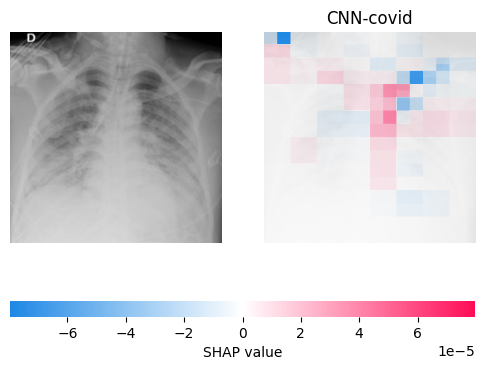

PartitionExplainer explainer: 2it [00:14, 14.08s/it]               


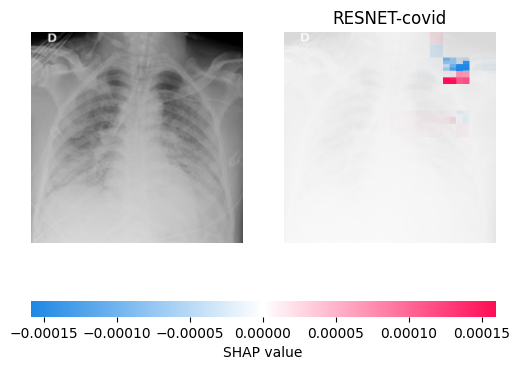

PartitionExplainer explainer: 2it [00:11, 11.22s/it]               


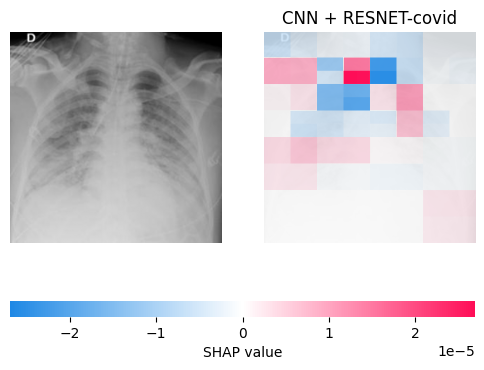

In [ ]:
# Suppress the model iteration printing
tf.keras.utils.disable_interactive_logging()

# Initialize image
image = pre_process('test/covid/COVID-673.jpg')

for i in range(3):
    # print(i)
    run_explainer(image, i)

## Combine Shapley Values
I never ended up using this in the project, but does serve as a proof of concept for gathering overall model information across multiple images

In [2]:
# Function for processing the image just like we did above
def pre_process(image_path):
    original_image = Image.open(image_path)
    preprocessed_image = original_image.resize((256, 256))
    preprocessed_image = np.array(preprocessed_image) / 255.0
    return np.expand_dims(preprocessed_image, axis = 0)


In [4]:
# Suppress the model iteration printing
tf.keras.utils.disable_interactive_logging()

iterations = 10
count = 0
predictions = []
class_names = ['covid','normal']
folder_path = 'C:/Users/Jon/Documents/School/CS 770/covid_data/test/normal/' 
model = tf.keras.models.load_model('C:/Users/Jon/Documents/School/CS 770/covid_data/covid_resnet_classifier_v2.h5') 
all_values = None

for filename in os.listdir(folder_path):
    if count < iterations:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
            image_path = os.path.join(folder_path, filename)
            image = pre_process(image_path)
            def f(preprocessed_image):
                preds = model.predict(preprocessed_image)
                return preds
            #Out of the box masker
            masker = shap.maskers.Image("blur(128,128)", image.shape[1:])

            # create an explainer with model and image masker
            explainer = shap.Explainer(f, masker, output_names=class_names)

            # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values

            shap_values = explainer(image, max_evals=500, batch_size=25, outputs=shap.Explanation.argsort.flip[:1])
            predictions.append(shap_values.output_names)
            if all_values == None:
                all_values = shap_values
            else:
                all_values += shap_values
            count += 1
    else:
        break


PartitionExplainer explainer: 2it [00:17, 17.03s/it]               
PartitionExplainer explainer: 2it [00:14, 14.96s/it]               
PartitionExplainer explainer: 2it [00:14, 14.18s/it]               
PartitionExplainer explainer: 2it [00:16, 16.06s/it]               
PartitionExplainer explainer: 2it [00:14, 14.62s/it]               
PartitionExplainer explainer: 2it [00:14, 14.80s/it]               
PartitionExplainer explainer: 2it [00:14, 14.64s/it]               
PartitionExplainer explainer: 2it [00:14, 14.69s/it]               
PartitionExplainer explainer: 2it [00:14, 14.95s/it]               
PartitionExplainer explainer: 2it [00:14, 14.75s/it]               


### It takes far too long to run so I did it on only a small sample
But below we can see the ResNet may have trained with some data leakage.
At the very least that is an odd accumulation of shapley values

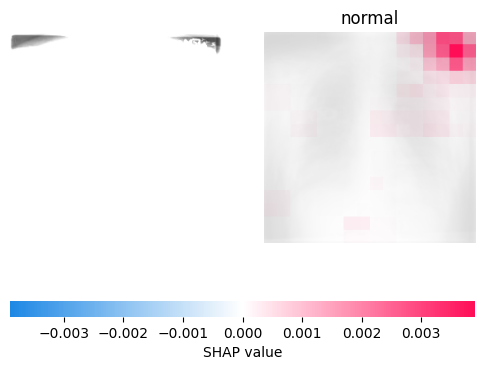

In [5]:
#Normal 
shap.image_plot(all_values)

In [6]:
# Show predictions to show what the model was prediciting, should be all the same class
predictions

[['normal'],
 ['normal'],
 ['normal'],
 ['normal'],
 ['normal'],
 ['normal'],
 ['normal'],
 ['normal'],
 ['normal'],
 ['normal']]